# 1.상장법인 코드 추출하기(yahoo finance)

In [2]:
# 코스닥, 코스피 종목코드 yf에서 추출
import pandas as pd
import FinanceDataReader as fdr

In [3]:
stocks = fdr.StockListing('KRX')

In [4]:
stocks

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,김세완,http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,"박대현, 손삼달",http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도
...,...,...,...,...,...,...,...,...,...,...
8254,003280,KOSPI,흥아해운,해상 운송업,외항화물운송업(케미컬탱커),1976-06-29,12월,이환구,http://www.heung-a.com,서울특별시
8255,037440,KOSDAQ,희림,"건축기술, 엔지니어링 및 관련 기술 서비스업",설계 및 감리용역,2000-02-03,12월,"정영균, 이목운, 허철호 (각자대표)",http://www.heerim.com,서울특별시
8256,419890,KOSPI,히어로즈 단기채권ESG액티브,NaN,NaN,NaT,NaN,NaN,NaN,NaN
8257,429870,KOSPI,히어로즈 리츠이지스액티브,NaN,NaN,NaT,NaN,NaN,NaN,NaN


In [5]:
stockcode = stocks[['Symbol', 'Market', 'Name']]

In [6]:
stockcode.head()

,Symbol,Market,Name
0,060310,KOSDAQ,3S
1,095570,KOSPI,AJ네트웍스
2,006840,KOSPI,AK홀딩스
3,054620,KOSDAQ,APS홀딩스
4,265520,KOSDAQ,AP시스템


In [7]:
# 해당하는 종목코드 추출
def code(stock):
    a = stockcode[stockcode['Name'] == stock]
    a_code = a['Symbol'].item()
    a_market = a['Market'].item()
    if a_market == 'KOSPI':
        a_market = '.KS'
    elif a_market == 'KOSDAQ':
        a_market = '.KQ'
    return a_code + a_market
    

In [227]:
code('삼성전자')[:6]

'005930'

# 2. 야후파이낸스에서 원하는 종목 수익률과 한달치 일별 수익률 변동 확인

In [9]:
import yfinance as yf
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib as plt

In [10]:
# 날짜: 자동으로 설정
# 티커: 함수이용

# 어제 수익률 보기
def yesterday_rtn(name):
    a = code(name)
    today = date.today()
    weekago = date.today() - relativedelta(weeks=1)
 
    df = yf.download(a, start=str(weekago), end=str(today), progess=False)
    df['daily_rtn'] = df['Adj Close'].pct_change()
    last_rtn = df['daily_rtn'][-1:].item()
    return last_rtn

# 한달동안 일별 수익률 추이 보기
def monthly_rtn_graph(name):
    a = code(name)
    today = date.today()
    monthago = date.today() - relativedelta(months=1)

    df = yf.download(a, start=str(monthago), end=str(today), progess=False)
    df['daily_rtn'] = df['Adj Close'].pct_change()

    return df['daily_rtn'].plot()

In [11]:
yesterday_rtn('삼성전자')

[*********************100%***********************]  1 of 1 completed


0.0014992503748125774

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

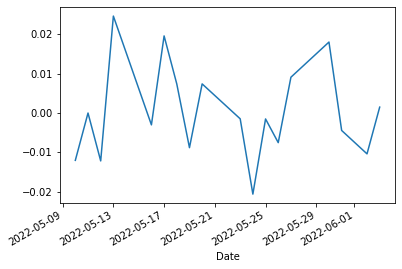

In [12]:
monthly_rtn_graph('삼성전자')

# 3. 한경컨센서스


In [13]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import FinanceDataReader as fdr
import re
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import numpy as np

In [14]:
today = date.today()
monthago = date.today() - relativedelta(months=1)

In [15]:
# stocks = fdr.StockListing('KRX') # 코스피, 코스닥, 코넥스 전체

In [16]:
stocks['Symbol'] = stocks['Symbol'].astype(str)
def remove_noise_and_split_title(title):
    in_code = ''
    in_name = ''
    
    for code, name in stocks[['Symbol', 'Name']].values:
        if code in title and name in title:
            in_code = code
            in_name = name
    
    # 한글, 영어, 숫자 외 노이즈 제거
    clean_title = re.sub('[^A-Za-z0-9가-힣]', ' ', title)
    
    # 기업명 코드 수정
    clean_title = clean_title.replace(in_code, ' ')
    clean_title = clean_title.replace(in_name, ' ')
    while ' ' * 2 in clean_title:
        clean_title = clean_title.replace(' ' * 2, ' ')
    
    if in_name == '': # 기업명이 없는 제목이라면, 데이터에 추가하지 않음
        return [None] 
    else:
        return [in_name, in_code, clean_title]  

In [17]:
# "http://consensus.hankyung.com/apps.analysis/analysis.list?&sdate=2016-09-01&edate=2021-08-31&report_type=CO&order_type=&now_page={}"
base_url = "http://hkconsensus.hankyung.com/apps.analysis/analysis.list?&sdate=%s&edate=%s&report_type=CO&order_type=&now_page={}"%(monthago, today) #오늘부터 한달전꺼 까지
data = [] 

for page_no in range(1,37):
    while True:
        try:
            url = base_url.format(page_no)
            html = requests.get(url, headers={'User-Agent':'Gils'}).content
            soup = BeautifulSoup(html, 'lxml')
            print("{}/{}".format(page_no, '37'))
            break
        except:
            time.sleep(15 * 60)

    table = soup.find("div", {"class":"table_style01"}).find('table')
    for tr in table.find_all("tr")[1:]: # 1번째 행부터 순회
        record = []
        for i, td in enumerate(tr.find_all("td")[:6]): # 6번째 셀까지 순회
            if i == 1:
                record += remove_noise_and_split_title(td.text) # remove_noise_title의 출력과 이어 붙임
            elif i == 3: # 노이즈가 껴있는 세번째 셀만 따로 처리
                record.append(td.text.replace(" ", "").replace("\r","").replace("\n",""))
            else: # 1번째 셀이 아니면:
                record.append(td.text) # 셀의 텍스트 값 그대로 입력
            
        if None not in record: # 레코드에 None이 없으면
            data.append(record)

    time.sleep(1) # 연결 끊김 방지를 위해, 1초씩 재움
    
data = pd.DataFrame(data, columns = ["작성일", "종목명", "종목코드", "제목", "적정가격", "평가의견", "작성자", "작성기관"])
data.to_csv("리포트_데이터.csv", index = False, encoding = "cp949")

1/37
2/37
3/37
4/37
5/37
6/37
7/37
8/37
9/37
10/37
11/37
12/37
13/37
14/37
15/37
16/37
17/37
18/37
19/37
20/37
21/37
22/37
23/37
24/37
25/37
26/37
27/37
28/37
29/37
30/37
31/37
32/37
33/37
34/37
35/37
36/37


In [18]:
def buy_sell(name):
    buyorsell = data[data['종목코드'] == code(name)[:6]]['평가의견']
    buyorsell[:1]

In [19]:
data.tail()

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관
660,2022-05-06,엔피케이,048830,인체적용시험 품목이 늘어나는 만큼 증가하는 인체적용시험 품목이 늘어나는 만큼 증가...,0,NotRated,나승두,SK증권
661,2022-05-06,카카오,035720,다시 톡 다시 톡 1Q22 매출은 예상치 소폭하회 영업이익은 부합 톡 중심의 재도...,"130,000",Buy,최관순,SK증권
662,2022-05-06,이지트로닉스,377330,폐배터리로 ESS 만든다 폐배터리로 ESS 만든다 전력전자기기의 필수품 전력변환장...,0,NotRated,나승두,SK증권
663,2022-05-06,오르비텍,046120,이래도 좋고 저래도 좋다 이래도 좋고 저래도 좋다 원자력발전 시설 관리 및 항공기...,0,NotRated,나승두,SK증권
664,2022-05-06,아비코전자,036010,실적으로 증명 실적으로 증명 1Q22 Review,None,None,None,None


In [20]:
def monthly_opinion(name):
    buyorsell = data[data['종목코드'] == code(name)[:6]]
    buyorsell = buyorsell[['작성일','작성기관','평가의견']]
    return buyorsell

In [21]:
# buyorsell_recent[:, np.newaxis]

In [22]:
# 1차 완성
def mystock(name):
    print(yesterday_rtn(name))
    print(monthly_opinion(name))

In [23]:
mystock('OCI')

[*********************100%***********************]  1 of 1 completed
0.03937007874015741
            작성일    작성기관 평가의견
42   2022-06-02  유진투자증권  Buy
115  2022-05-31   메리츠증권  Buy
642  2022-05-06   메리츠증권  Buy


# 4. 종토방 댓글 내용 / 갯수 count 하기

In [75]:

# url = "https://finance.naver.com/item/board.naver?code=%s&page=1"%code('삼성전자')[:6]

# headers = { 'User-Agent': 'Mozilla/5.0 (Windows NT 6.0; WOW64; rv:24.0) Gecko/20100101 Firefox/24.0' }

# resp = requests.get(url, headers=headers)

# soup = BeautifulSoup(resp.text, "html.parser")

# reply_date = soup.find_all('span', {'class':'tah p10 gray03'})

In [228]:
code('OCI')

'010060.KS'

In [229]:
def 
base_url_2 = "https://finance.naver.com/item/board.naver?code=%s&page={}"%(code(name))

def naver_crawling(name):
    b = []
    
    for i in range(1001):
        url = base_url_2.format(i)
        headers = { 'User-Agent': 'Mozilla/5.0 (Windows NT 6.0; WOW64; rv:24.0) Gecko/20100101 Firefox/24.0' }

        resp = requests.get(url, headers=headers)
        soup = BeautifulSoup(resp.text, "html.parser")
        reply_date = soup.find_all('span', {'class':'tah p10 gray03'})
        
        for i in reply_date:
            b.append(i.string)
    return b
# find('reply_date')['tah p10 gray03']

NameError: name 'name' is not defined

In [225]:
naver_crawling(100)

KeyboardInterrupt: 

In [189]:
samsung[-5:]

['529', '2022.05.21 01:13', '501', '2022.05.21 01:11', '605']

In [190]:
# 어제,아레 만들어서 형식 고치기
ytd = str(date.today() - relativedelta(days=1))
true_ytd = ytd[:4] + '.' + ytd[5:7] + '.' + ytd[8:10]

twodaysago = str(date.today() - relativedelta(days=2))
twodaysago = twodaysago[:4] + '.' + twodaysago[5:7] + '.' + twodaysago[8:10]


'2022.06.03'

In [231]:
# 댓글 갯수 예시
temp_minus_1=[]
temp_minus_2=[]

for i in range(len(samsung)):
    if samsung[i][:10] == true_ytd:
        temp_minus_1.append(samsung[i])
    elif samsung[i][:10] == twodaysago:
        temp_minus_2.append(samsung[i])
    else:
        pass
    
reply_vol =((len(temp_minus_1) - len(temp_minus_2)) / len(temp_minus_2)) # 아레 대비 어제 댓글 수 변화
reply_vol

-0.26045883940620784

In [198]:
# 2차 완성..을 못했어요....힘드러요.....미안해요....능력부족이에요...
def mystock(name):
    print(yesterday_rtn(name))
    print(monthly_opinion(name))
    # print(reply_volatility(name))

1096